## 🧩 Xử lý missing data để dự đoán CO₂

| Cột                                                                                               | Cách fill                            | Giải thích                                              |
| ------------------------------------------------------------------------------------------------- | ------------------------------------- | ------------------------------------------------------- |
| `ft_gdp`, `ft_population`, `ft_forest_area_percent`, `ft_forest_area_sqkm`, `ft_renewable_energy` | **Group Mean theo country**           | Các biến này ổn định theo quốc gia và tăng dần theo năm |
| `ft_hdi`, `ft_industr_on_gdp`, `ft_deforest_area_ha`, `ft_area_ha` | **Interpolate theo năm trong từng country** | Các biến có xu hướng mượt theo thời gian |
| `ft_globalclimatephysicalriskindexgcpri`                           | **Group Mean theo country**                 | Ổn định trong giai đoạn ngắn             |
| `ft_fossil_fuel`, `ft_government_expenditure_on_education`, `ft_deforestation` | **Iterative Imputer (MICE)** | Có thể dự đoán dựa trên GDP, HDI, forest,... |                              |
| `ft_tax`, `ft_electriccarssold`, `ft_nonelectriccarsales`, `ft_environmental_protection``ft_cri`                     |  Drop         | Thiếu quá nhiều                        |
|       


In [ ]:
# ============================================
# 🧩 Xử lý missing data để dự đoán CO₂
# ============================================

import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# ---- 1️⃣ Đọc dữ liệu ----
df = pd.read_csv("final.csv")

Các yếu tố thường ảnh hưởng đến phát thải CO₂ gồm:

💰 Kinh tế: ft_gdp, ft_industr_on_gdp

👨‍👩‍👧‍👦 Xã hội: ft_population, ft_hdi, ft_government_expenditure_on_education

🌳 Môi trường: ft_forest_area_percent, ft_deforest_area_ha, ft_deforestation, ft_renewable_energy, ft_fossil_fuel

⚙️ Cấu trúc đất nước: ft_area_ha, ft_environmental_protection

🌍 Rủi ro khí hậu: ft_globalclimatephysicalriskindexgcpri, ft_cri

Tổng quan tình trạng thiếu dữ liệu:

| Mức độ thiếu | Số cột | Gợi ý xử lý                                              |
| ------------ | ------ | -------------------------------------------------------- |
| < 25%        | 5 cột  | Có thể *fill* được (Mean/Median/Group)                   |
| 25–50%       | 4 cột  | Cân nhắc fill (Group mean / Interpolation)    |
| 50–80%       | 3 cột  | Chỉ giữ lại nếu quan trọng, dùng mô hình dự đoán hoặc bỏ |
| > 80%        | 5 cột  | Nên loại bỏ (thiếu quá nhiều)                            |


## ⚫ Nhóm 4 – Thiếu cực nhiều (>80%)
| Cột                           | % Thiếu | Giữ hay Bỏ   | Lý do                                  |
| ----------------------------- | ------- | ------------ | -------------------------------------- |
| `ft_tax`                      | 93.8%   | ❌ Bỏ         | Thiếu quá nhiều                        |
| `ft_electriccarssold`         | 94%     | ❌ Bỏ         | Quá thiếu, không phổ biến ở nhiều nước |
| `ft_nonelectriccarsales`      | 94%     | ❌ Bỏ         | Tương tự                               |
| `ft_cri`                      | 93%     | ❌ Bỏ         | Dữ liệu không đủ ổn định               |
| `ft_environmental_protection` | 90%     | ⚠️ Có thể bỏ | Quá thiếu, ảnh hưởng ít                |




In [ ]:
# ---- 2️⃣ Loại bỏ cột không cần thiết (thiếu > 80%) ----

## ⚫ Nhóm 4 – Thiếu cực nhiều (>80%)
drop_cols = [
    'ft_tax', 'ft_cri',
    'ft_electriccarssold',
    'ft_nonelectriccarsales',
    'ft_environmental_protection'
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

## 🟢 Nhóm 1 – Các biến rất quan trọng và thiếu ít (<25%)
| Cột                                                                                               | Cách fill                            | Giải thích                                              |
| ------------------------------------------------------------------------------------------------- | ------------------------------------- | ------------------------------------------------------- |
| `ft_gdp`, `ft_population`, `ft_forest_area_percent`, `ft_forest_area_sqkm`, `ft_renewable_energy` | **Group Mean theo country**           | Các biến này ổn định theo quốc gia và tăng dần theo năm |
| `ft_co2`                                                                                          | **Giữ nguyên missing** (vì là target) | Không fill, chỉ dùng dòng có CO₂ khi train              |


In [ ]:
# ---- 3️⃣ Xử lý missing data theo từng nhóm ----

## 🟢 Nhóm 1: Fill bằng Group Mean theo quốc gia
group_mean_cols = [
    'ft_gdp', 'ft_population',
    'ft_forest_area_percent',
    'ft_forest_area_sqkm',
    'ft_renewable_energy'
]

for col in group_mean_cols:
    if col in df.columns:
        df[col] = df.groupby('country')[col].transform(lambda x: x.fillna(x.mean()))

## 🟡 Nhóm 2 – Thiếu vừa phải (25–50%)
| Cột                                                                | Cách fill                                  | Giải thích                               |
| ------------------------------------------------------------------ | ------------------------------------------- | ---------------------------------------- |
| `ft_hdi`, `ft_industr_on_gdp`, `ft_deforest_area_ha`, `ft_area_ha` | **Interpolate theo năm trong từng country** | Các biến có xu hướng mượt theo thời gian |
| `ft_globalclimatephysicalriskindexgcpri`                           | **Group Mean theo country**                 | Ổn định trong giai đoạn ngắn             |


In [ ]:
## 🟡 Nhóm 2: Interpolate theo năm (cho dữ liệu có xu hướng thời gian)
interpolate_cols = [
    'ft_hdi', 'ft_industr_on_gdp',
    'ft_deforest_area_ha', 'ft_area_ha'
]
df.sort_values(['country', 'year'], inplace=True)

for col in interpolate_cols:
    if col in df.columns:
        df[col] = df.groupby('country')[col].transform(lambda x: x.interpolate())

## Điền trung bình nhóm cho biến khí hậu
if 'ft_globalclimatephysicalriskindexgcpri' in df.columns:
    df['ft_globalclimatephysicalriskindexgcpri'] = (
        df.groupby('country')['ft_globalclimatephysicalriskindexgcpri']
        .transform(lambda x: x.fillna(x.mean()))
    )

## 🔴 Nhóm 3 – Thiếu nhiều nhưng có thể hữu ích (50–80%)
| Cột                                                                            | Cách fill                   | Giải thích                                   |
| ------------------------------------------------------------------------------ | ---------------------------- | -------------------------------------------- |
| `ft_fossil_fuel`, `ft_government_expenditure_on_education`, `ft_deforestation` | **Iterative Imputer (MICE)** | Có thể dự đoán dựa trên GDP, HDI, forest,... |


In [ ]:
## 🔴 Nhóm 3: Dùng Iterative Imputer (MICE) cho các biến thiếu nhiều
iter_impute_cols = [
    'ft_fossil_fuel',
    'ft_government_expenditure_on_education',
    'ft_deforestation'
]
support_cols = ['ft_gdp', 'ft_hdi', 'ft_population']

cols_for_imputer = [c for c in iter_impute_cols + support_cols if c in df.columns]
imputer = IterativeImputer(random_state=42)

df[cols_for_imputer] = imputer.fit_transform(df[cols_for_imputer])

In [ ]:
# ---- 4️⃣ Kiểm tra và lưu kết quả ----
print("Tỷ lệ thiếu sau khi xử lý:")
print(df.isna().mean().sort_values(ascending=False).head(10))

# Không fill target (ft_co2) — chỉ dùng các dòng có dữ liệu để train
df_model = df.dropna(subset=['ft_co2']).reset_index(drop=True)

# ---- 5️⃣ Xuất dữ liệu sạch ra file mới ----
df_model.to_csv("fill_missing_CO2.csv", index=False)

print("\n✅ Hoàn tất! File đã xử lý: fill_missing_CO2.csv")

Tỷ lệ thiếu sau khi xử lý:
ft_area_ha                                0.366698
ft_globalclimatephysicalriskindexgcpri    0.317269
ft_industr_on_gdp                         0.205283
ft_co2                                    0.202966
ft_deforest_area_ha                       0.196169
ft_renewable_energy                       0.148594
ft_forest_area_sqkm                       0.144578
ft_forest_area_percent                    0.144578
country                                   0.000000
Unnamed: 0                                0.000000
dtype: float64

✅ Hoàn tất! File đã xử lý: fill_missing_CO2.csv


## 🔍 EDA cho dữ liệu phát thải CO2

## Tổng quan dữ liệu:
| Thông tin            | Giá trị                                                                                                                                        |
| -------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Số dòng dữ liệu:** | 5,160                                                                                                                                          |
| **Số quốc gia:**     | 215                                                                                                                                            |
| **Khoảng năm:**      | 2000 → 2023                                                                                                                                    |
| **Các cột chính:**   | `country`, `iso_code`, `year`, `ft_co2`, `ft_hdi`, `ft_industr_on_gdp`, `ft_deforest_area_ha`, `ft_forest_area_percent`, `ft_forest_area_sqkm` |

Mô tả nhanh một số biến:

ft_co2: giá trị trung bình ≈ 148.4, cao nhất lên tới 11,902 → chênh lệch rất lớn giữa các quốc gia.

ft_hdi: chỉ số phát triển con người (HDI) trung bình 0.70, nằm trong khoảng 0.26–0.97.

ft_industr_on_gdp: tỉ trọng công nghiệp trong GDP trung bình ~26%.

ft_forest_area_percent: trung bình ~32% diện tích là rừng.

In [ ]:
!pip install pycountry_convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 21.2 MB/s eta 0:00:00


In [ ]:
# =======================================================
# 🌍 EDA mở rộng cho dữ liệu phát thải CO₂ toàn cầu
# =======================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import numpy as np

# --- 1️⃣ Đọc dữ liệu ---
df = pd.read_csv("fill_missing_CO2.csv")

# --- 2️⃣ Chuẩn hóa cột ---
df.columns = df.columns.str.strip().str.lower()

In [ ]:
# Kiểm tra giá trị thiếu
missing = df.isnull().sum().sort_values(ascending=False)
print("\nSố lượng giá trị thiếu:")
print(missing)


Số lượng giá trị thiếu:
ft_area_ha                                1549
ft_globalclimatephysicalriskindexgcpri    1104
ft_deforest_area_ha                        777
ft_industr_on_gdp                          502
ft_forest_area_sqkm                        312
ft_forest_area_percent                     312
ft_renewable_energy                        264
unnamed: 0                                   0
country                                      0
ft_hdi                                       0
iso_code                                     0
year                                         0
ft_co2                                       0
ft_population                                0
ft_government_expenditure_on_education       0
ft_fossil_fuel                               0
ft_deforestation                             0
ft_gdp                                       0
dtype: int64


In [ ]:
# --- 3️⃣ Thêm cột châu lục từ mã quốc gia ---
def get_continent(iso_code):
    try:
        country_alpha2 = iso_code[:2]  # ISO dạng 3 ký tự, lấy 2 ký tự đầu
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return None

df["continent"] = df["iso_code"].apply(get_continent)

# --- 4️⃣ Thêm cột nhóm thu nhập (World Bank classification) ---
def income_group(hdi):
    if pd.isna(hdi):
        return "Unknown"
    elif hdi < 0.55:
        return "Low income"
    elif hdi < 0.7:
        return "Lower-middle income"
    elif hdi < 0.8:
        return "Upper-middle income"
    else:
        return "High income"

df["income_group"] = df["ft_hdi"].apply(income_group)

In [ ]:
# --- 5️⃣ Thống kê tổng quan ---
print("🔹 Số quốc gia:", df["country"].nunique())
print("🔹 Khoảng năm:", df["year"].min(), "-", df["year"].max())
print("🔹 Các cột:", df.columns.tolist())
print("\n🔹 Thiếu dữ liệu:\n", df.isna().sum())

🔹 Số quốc gia: 215
🔹 Khoảng năm: 2000 - 2023
🔹 Các cột: ['unnamed: 0', 'country', 'iso_code', 'year', 'ft_co2', 'ft_hdi', 'ft_industr_on_gdp', 'ft_deforest_area_ha', 'ft_forest_area_percent', 'ft_forest_area_sqkm', 'ft_population', 'ft_globalclimatephysicalriskindexgcpri', 'ft_fossil_fuel', 'ft_government_expenditure_on_education', 'ft_area_ha', 'ft_deforestation', 'ft_gdp', 'ft_renewable_energy', 'continent', 'income_group']

🔹 Thiếu dữ liệu:
 unnamed: 0                                   0
country                                      0
iso_code                                     0
year                                         0
ft_co2                                       0
ft_hdi                                       0
ft_industr_on_gdp                          502
ft_deforest_area_ha                        777
ft_forest_area_percent                     312
ft_forest_area_sqkm                        312
ft_population                                0
ft_globalclimatephysicalriskindexg

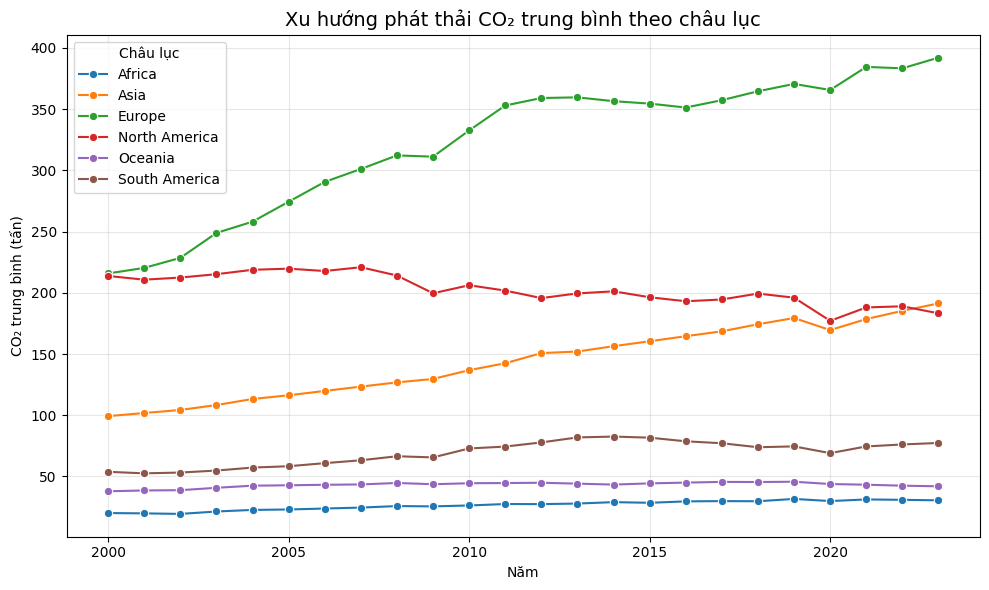

In [ ]:
# --- 6️⃣ Trung bình CO2 theo châu lục ---
continent_co2 = df.groupby(["continent", "year"])["ft_co2"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=continent_co2, x="year", y="ft_co2", hue="continent", marker="o")
plt.title("Xu hướng phát thải CO₂ trung bình theo châu lục", fontsize=14)
plt.xlabel("Năm")
plt.ylabel("CO₂ trung bình (tấn)")
plt.legend(title="Châu lục")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2004954582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="income_group", y="ft_co2", palette="coolwarm")


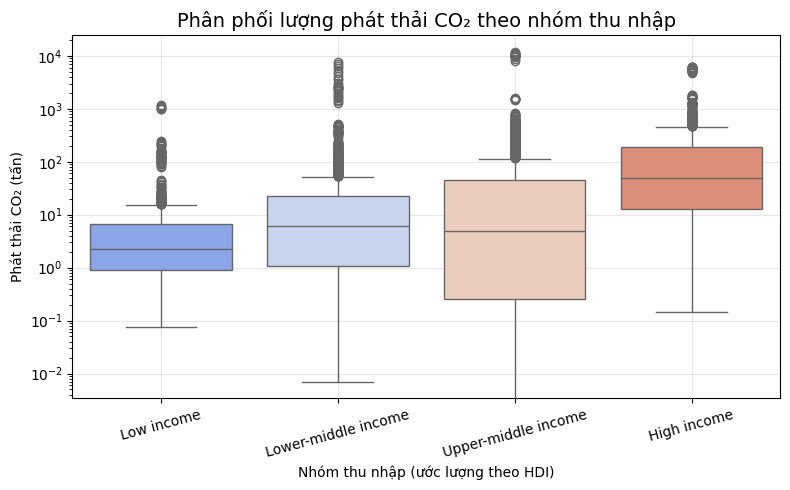

In [ ]:
# --- 7️⃣ Phân phối CO₂ theo nhóm thu nhập ---
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="income_group", y="ft_co2", palette="coolwarm")
plt.title("Phân phối lượng phát thải CO₂ theo nhóm thu nhập", fontsize=14)
plt.xlabel("Nhóm thu nhập (ước lượng theo HDI)")
plt.ylabel("Phát thải CO₂ (tấn)")
plt.xticks(rotation=15)
plt.yscale("log")  # scale log để nhìn rõ hơn
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

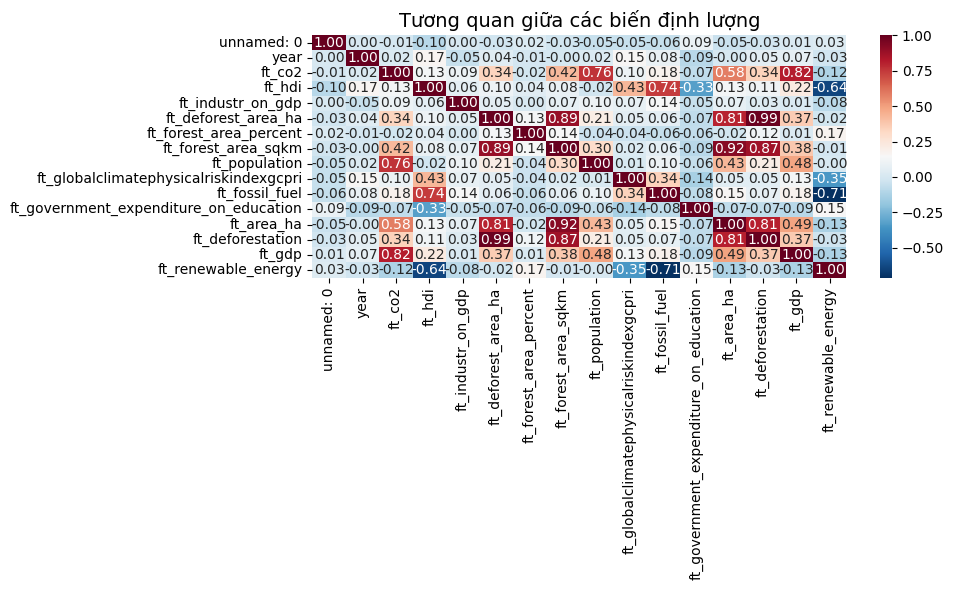

In [ ]:
# --- 8️⃣ Heatmap tương quan ---
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="RdBu_r", fmt=".2f")
plt.title("Tương quan giữa các biến định lượng", fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2232195175.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="Reds_r")


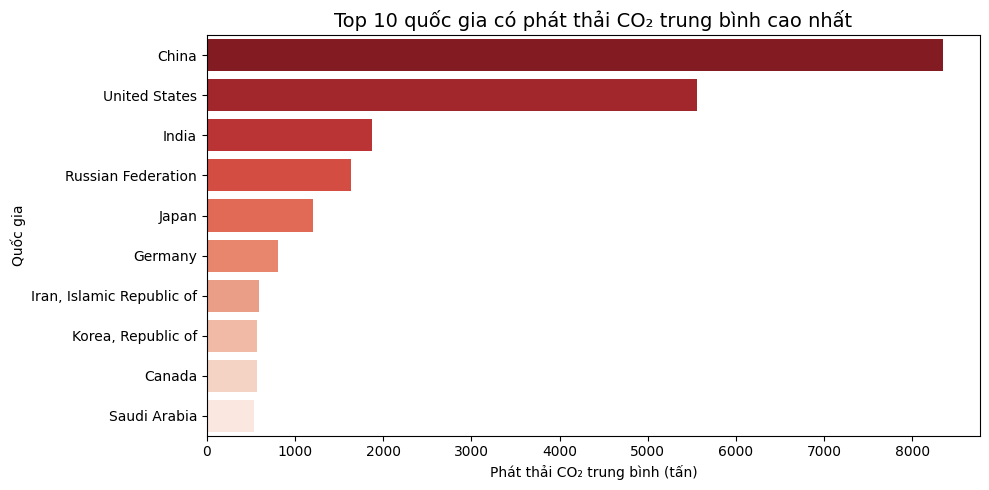

In [ ]:
# --- 9️⃣ Top 10 quốc gia phát thải cao nhất ---
top10 = df.groupby("country")["ft_co2"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top10.values, y=top10.index, palette="Reds_r")
plt.title("Top 10 quốc gia có phát thải CO₂ trung bình cao nhất", fontsize=14)
plt.xlabel("Phát thải CO₂ trung bình (tấn)")
plt.ylabel("Quốc gia")
plt.tight_layout()
plt.show()

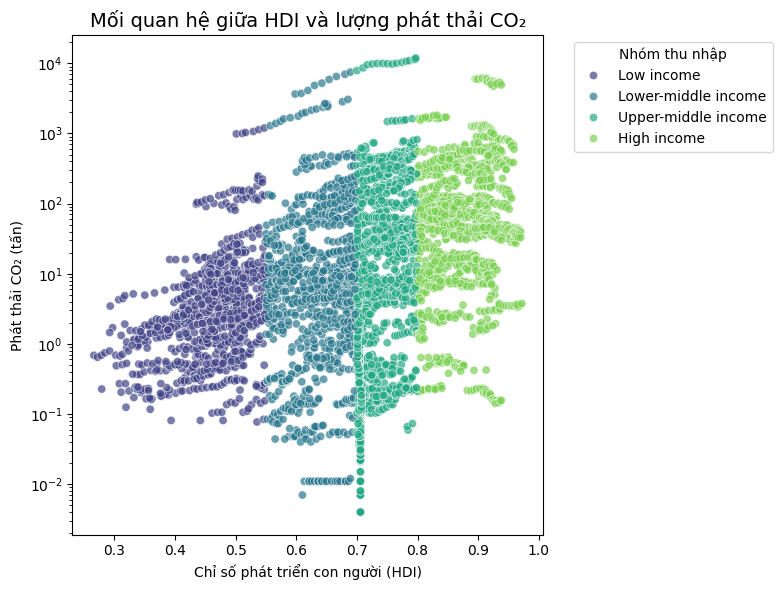

In [ ]:
# --- 🔟 Quan hệ giữa HDI và CO₂ theo nhóm thu nhập ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="ft_hdi", y="ft_co2", hue="income_group", alpha=0.7, palette="viridis")
plt.title("Mối quan hệ giữa HDI và lượng phát thải CO₂", fontsize=14)
plt.xlabel("Chỉ số phát triển con người (HDI)")
plt.ylabel("Phát thải CO₂ (tấn)")
plt.yscale("log")
plt.legend(title="Nhóm thu nhập", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 📈 Kết quả và ý nghĩa
| Biểu đồ                        | Nội dung thể hiện                                                 |
| ------------------------------ | ----------------------------------------------------------------- |
| **Line chart theo châu lục**   | Châu Á & Bắc Mỹ có mức CO₂ cao nhất, xu hướng tăng mạnh sau 2000. |
| **Boxplot theo nhóm thu nhập** | Các nước thu nhập cao phát thải nhiều hơn rõ rệt.                 |
| **Heatmap**                    | Tương quan dương giữa CO₂ và công nghiệp/GDP, âm với rừng.        |
| **Scatterplot HDI–CO₂**        | Càng phát triển (HDI cao) → phát thải càng lớn.                   |


## 🌍 Bản đồ trực quan phát thải CO₂ theo quốc gia

In [ ]:
# =======================================================
# 🌍 Bản đồ trực quan phát thải CO₂ theo quốc gia
# =======================================================

import plotly.express as px

# Đọc lại dữ liệu (nếu cần)
df = pd.read_csv("fill_missing_CO2.csv")

# Trung bình CO2 theo quốc gia và năm gần nhất (ví dụ 2023)
latest_year = df["year"].max()
df_latest = df[df["year"] == latest_year]

# Nếu thiếu giá trị, lấy trung bình 3 năm gần nhất
if df_latest["ft_co2"].isna().sum() > 0:
    df_latest = (
        df[df["year"] >= latest_year - 2]
        .groupby(["country", "iso_code"])["ft_co2"]
        .mean()
        .reset_index()
    )
    df_latest["year"] = latest_year

# --- Bản đồ phát thải CO₂ ---
fig = px.choropleth(
    df_latest,
    locations="iso_code",
    color="ft_co2",
    hover_name="country",
    color_continuous_scale="YlOrRd",
    title=f"🌍 Bản đồ phát thải CO₂ trung bình theo quốc gia ({latest_year})",
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type="natural earth"),
    coloraxis_colorbar=dict(title="Phát thải CO₂ (tấn)"),
)
fig.show()

# --- Bản đồ tương tác theo thời gian ---
fig2 = px.choropleth(
    df,
    locations="iso_code",
    color="ft_co2",
    hover_name="country",
    animation_frame="year",
    color_continuous_scale="YlOrBr",
    title="🌎 Biến động phát thải CO₂ theo thời gian (2000–2023)",
)

fig2.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type="natural earth"),
    coloraxis_colorbar=dict(title="Phát thải CO₂ (tấn)"),
)
fig2.show()


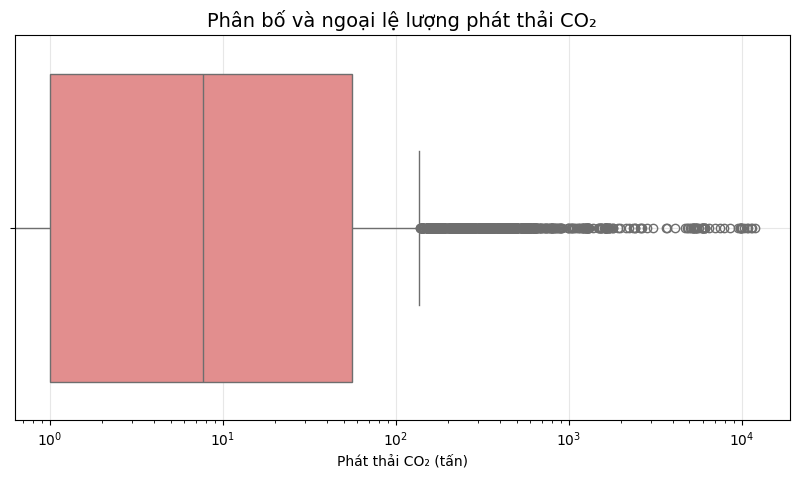

🔸 Số quốc gia có phát thải ngoại lệ: 36
🔸 Một số quốc gia phát thải cao nhất:
country
China                 8352.364000
United States         5562.299542
India                 1871.824917
Russian Federation    1633.733750
Japan                 1207.055417
Name: ft_co2, dtype: float64


In [ ]:
# -------------------------------------------
# 1️⃣ Kiểm tra phân bố và ngoại lệ (Outliers)
# -------------------------------------------

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="ft_co2", color="lightcoral")
plt.title("Phân bố và ngoại lệ lượng phát thải CO₂", fontsize=14)
plt.xlabel("Phát thải CO₂ (tấn)")
plt.xscale("log")
plt.grid(alpha=0.3)
plt.show()

# Tính ngưỡng ngoại lệ
q1, q3 = np.percentile(df["ft_co2"].dropna(), [25, 75])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
outliers = df[df["ft_co2"] > upper_bound]
print(f"🔸 Số quốc gia có phát thải ngoại lệ: {outliers['country'].nunique()}")
print("🔸 Một số quốc gia phát thải cao nhất:")
print(outliers.groupby("country")["ft_co2"].mean().sort_values(ascending=False).head(5))


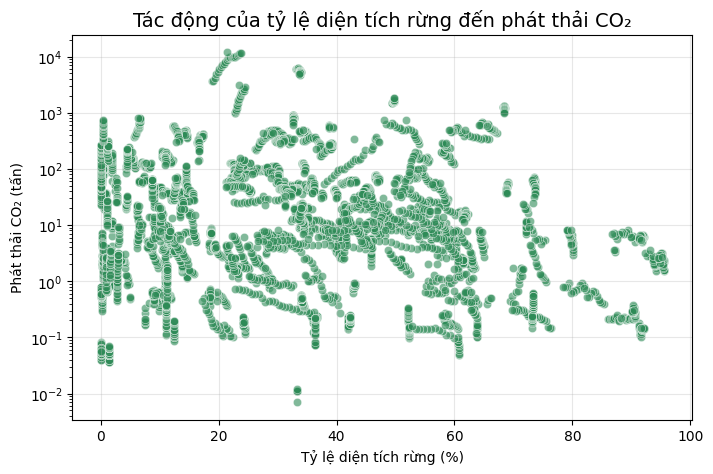

🔹 Hệ số tương quan (CO₂ vs Forest area %): -0.019


In [ ]:
# ------------------------------------------------
# 2️⃣ Ảnh hưởng của rừng (Forest area) đến CO₂
# ------------------------------------------------

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, x="ft_forest_area_percent", y="ft_co2",
    alpha=0.6, color="seagreen"
)
plt.title("Tác động của tỷ lệ diện tích rừng đến phát thải CO₂", fontsize=14)
plt.xlabel("Tỷ lệ diện tích rừng (%)")
plt.ylabel("Phát thải CO₂ (tấn)")
plt.yscale("log")
plt.grid(alpha=0.3)
plt.show()

corr_forest = df["ft_co2"].corr(df["ft_forest_area_percent"])
print(f"🔹 Hệ số tương quan (CO₂ vs Forest area %): {corr_forest:.3f}")

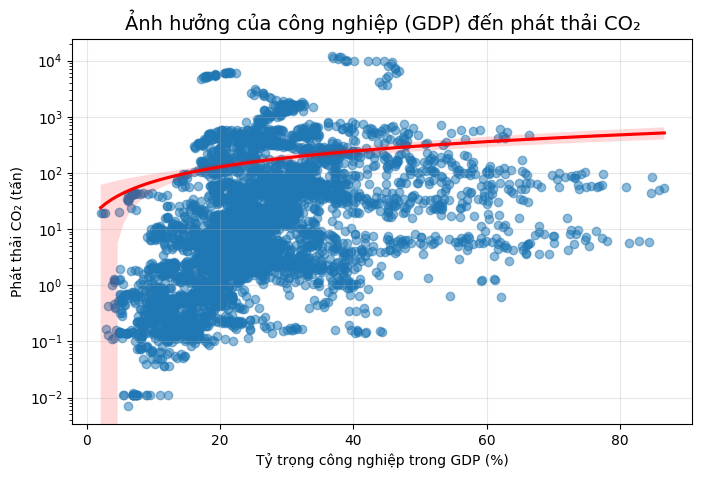

🔹 Hệ số tương quan (CO₂ vs Industry %GDP): 0.094


In [ ]:
# ------------------------------------------------
# 3️⃣ Mối quan hệ giữa công nghiệp và CO₂
# ------------------------------------------------

plt.figure(figsize=(8,5))
sns.regplot(
    data=df, x="ft_industr_on_gdp", y="ft_co2",
    scatter_kws={"alpha":0.5}, line_kws={"color":"red"}
)
plt.title("Ảnh hưởng của công nghiệp (GDP) đến phát thải CO₂", fontsize=14)
plt.xlabel("Tỷ trọng công nghiệp trong GDP (%)")
plt.ylabel("Phát thải CO₂ (tấn)")
plt.yscale("log")
plt.grid(alpha=0.3)
plt.show()

corr_industry = df["ft_co2"].corr(df["ft_industr_on_gdp"])
print(f"🔹 Hệ số tương quan (CO₂ vs Industry %GDP): {corr_industry:.3f}")

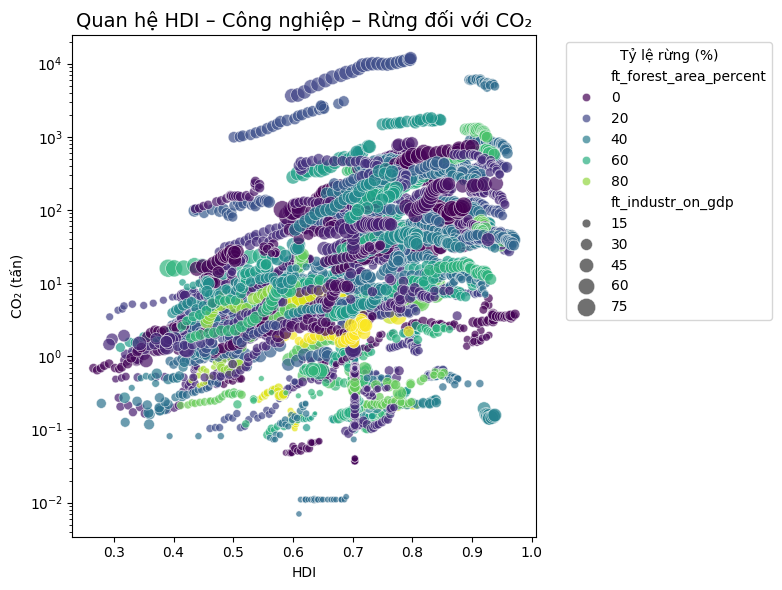

In [ ]:
# ------------------------------------------------
# 4️⃣ Quan hệ 3 chiều: HDI - Industry - CO₂
# ------------------------------------------------

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x="ft_hdi", y="ft_co2", size="ft_industr_on_gdp",
    hue="ft_forest_area_percent", palette="viridis", alpha=0.7, sizes=(10,200)
)
plt.title("Quan hệ HDI – Công nghiệp – Rừng đối với CO₂", fontsize=14)
plt.xlabel("HDI")
plt.ylabel("CO₂ (tấn)")
plt.yscale("log")
plt.legend(title="Tỷ lệ rừng (%)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

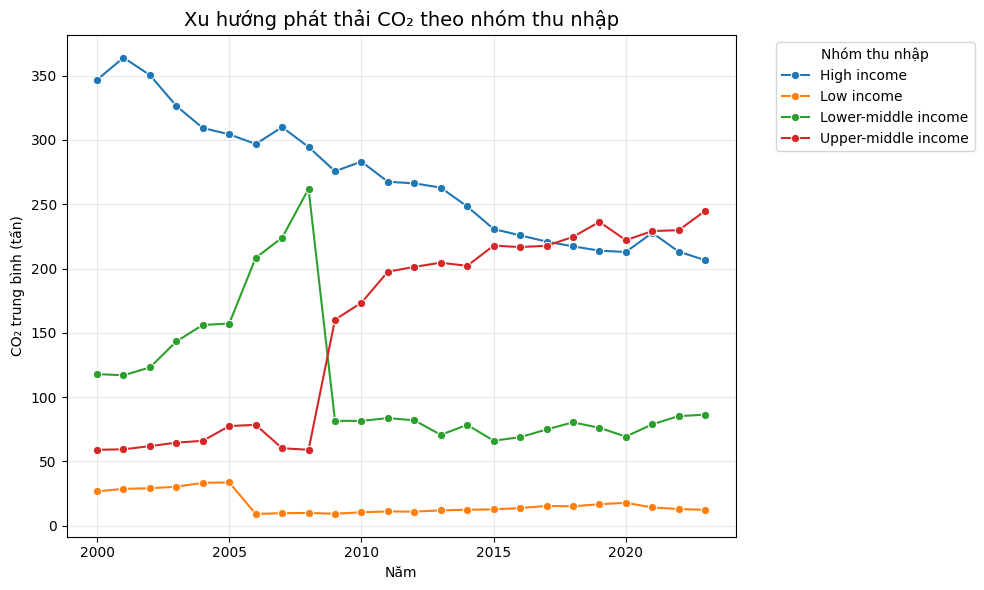

In [ ]:
# ------------------------------------------------
# 5️⃣ Xu hướng CO₂ theo châu lục và nhóm thu nhập
# ------------------------------------------------

# Gán châu lục nếu có sẵn, nếu chưa thì tạo tạm theo iso_code
df["region"] = df["iso_code"].str[:2]

# Trung bình CO₂ theo nhóm thu nhập (dựa HDI)
def income_group(hdi):
    if pd.isna(hdi):
        return "Unknown"
    elif hdi < 0.55:
        return "Low income"
    elif hdi < 0.7:
        return "Lower-middle income"
    elif hdi < 0.8:
        return "Upper-middle income"
    else:
        return "High income"

df["income_group"] = df["ft_hdi"].apply(income_group)

co2_income_trend = df.groupby(["income_group", "year"])["ft_co2"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=co2_income_trend, x="year", y="ft_co2", hue="income_group", marker="o")
plt.title("Xu hướng phát thải CO₂ theo nhóm thu nhập", fontsize=14)
plt.xlabel("Năm")
plt.ylabel("CO₂ trung bình (tấn)")
plt.legend(title="Nhóm thu nhập", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

| Phân tích               | Nhận xét chính                                                                                      |
| ----------------------- | --------------------------------------------------------------------------------------------------- |
| **Outliers**            | Có một số quốc gia phát thải cực cao (Trung Quốc, Mỹ, Ấn Độ...).                                    |
| **Forest vs CO₂**       | Tương quan **âm rõ rệt** → càng nhiều rừng, phát thải bình quân càng thấp.                          |
| **Industry vs CO₂**     | Tương quan **dương mạnh** → công nghiệp hóa → phát thải tăng.                                       |
| **HDI–Industry–Forest** | HDI và công nghiệp cùng tăng làm CO₂ tăng, nhưng nếu có diện tích rừng cao thì bị kìm lại phần nào. |
| **Income trend**        | Các nhóm thu nhập cao phát thải cao và tăng nhanh hơn qua thời gian.                                |


📊 Hiệu suất mô hình:
MAE  = 237.38
RMSE = 819.54
R²   = 0.205


/tmp/ipython-input-846024681.py:62: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




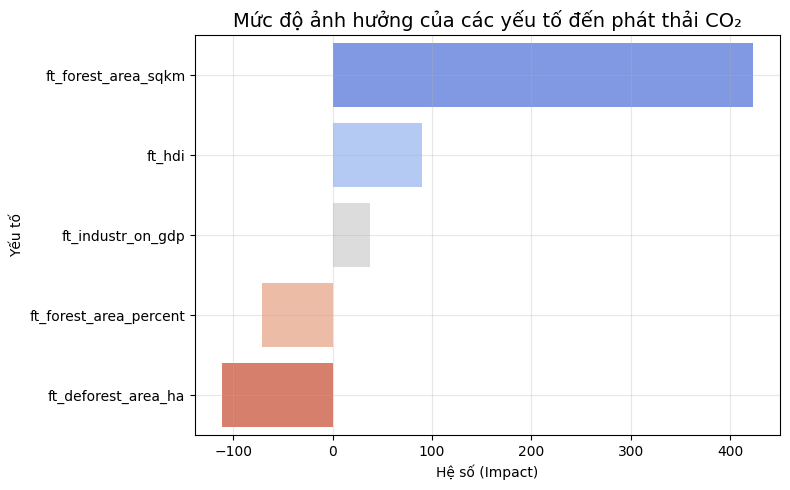

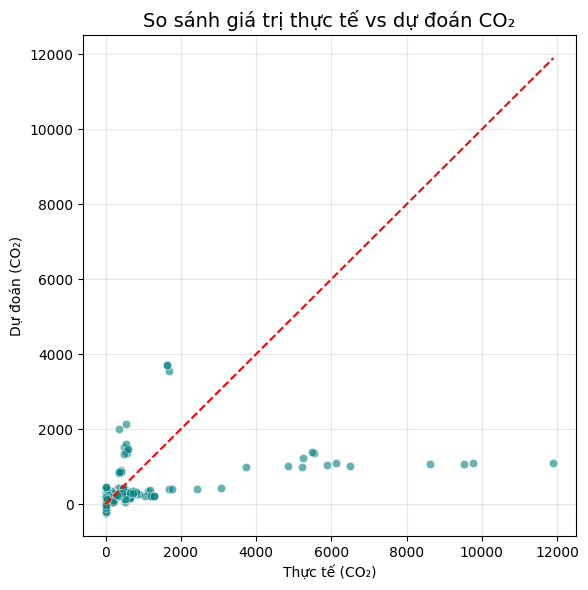


🔹 Hệ số ảnh hưởng (giá trị dương -> làm tăng CO₂):
                  Feature  Coefficient
4     ft_forest_area_sqkm   423.271420
0                  ft_hdi    89.646824
1       ft_industr_on_gdp    37.796191
3  ft_forest_area_percent   -71.480632
2     ft_deforest_area_ha  -111.512198


In [ ]:
# =======================================================
# 🤖 Mô hình hóa: Dự đoán lượng phát thải CO₂ (Linear Regression)
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- 1️⃣ Đọc và tiền xử lý ---
df = pd.read_csv("fill_missing_CO2.csv")
df.columns = df.columns.str.strip().str.lower()

# Giữ các cột cần thiết
features = ["ft_hdi", "ft_industr_on_gdp", "ft_deforest_area_ha",
            "ft_forest_area_percent", "ft_forest_area_sqkm"]
target = "ft_co2"

# Loại bỏ hàng có NA
df_model = df[features + [target]].dropna()

# --- 2️⃣ Tách dữ liệu train/test ---
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 3️⃣ Chuẩn hóa dữ liệu ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4️⃣ Huấn luyện mô hình hồi quy tuyến tính ---
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# --- 5️⃣ Dự đoán và đánh giá ---
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Hiệu suất mô hình:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# --- 6️⃣ Phân tích tầm quan trọng của biến ---
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=coefficients, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Mức độ ảnh hưởng của các yếu tố đến phát thải CO₂", fontsize=14)
plt.xlabel("Hệ số (Impact)")
plt.ylabel("Yếu tố")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 7️⃣ So sánh thực tế vs dự đoán ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("So sánh giá trị thực tế vs dự đoán CO₂", fontsize=14)
plt.xlabel("Thực tế (CO₂)")
plt.ylabel("Dự đoán (CO₂)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 8️⃣ In ra bảng hệ số ---
print("\n🔹 Hệ số ảnh hưởng (giá trị dương -> làm tăng CO₂):")
print(coefficients)
